In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns


## Functions needed

def pos_xy_to_angle(x, y):
    deg = np.degrees(np.arctan2(y,x))
    if deg<0:
        deg=360-abs(deg)
    
    deg=int(deg)
    return deg



def RFangle_2_octaves(angle):
    ## round RF to octave
    value = min([0, 45, 90, 135, 180, 225, 270, 315, 360], key=lambda x:abs(x-angle))
    
    if value==360:
        value=0
    
    return value


RFangle_2_octaves(329)    

def angle_from_RF(loc_angle, RF_angle):
    ## change from position of target to angle taking into account the RF
    angle_target = RFangle_2_octaves(RF_angle)
    angle_dist = angle_target + 45*loc_angle
    if angle_dist>=360:
        angle_dist=angle_dist-360
    
    if loc_angle==99:
        angle_dist=np.nan
    
    return angle_dist


# x_rf=f['data']['info'][0][0][0][1][0][25][0][0]
# y_rf=f['data']['info'][0][0][0][1][0][26][0][0]

# RF_angle = pos_xy_to_angle(x_rf, y_rf)
# RF_loc = RFangle_2_octaves(RF_angle)


# Dist_loc = angle_from_RF(99, RF_loc)

# print(RF_angle, RF_loc, Dist_loc)
def RFangle_2_octaves(angle):
    ## round RF to octave
    value = min([0, 45, 90, 135, 180, 225, 270, 315, 360], key=lambda x:abs(x-angle))
    
    if value==360:
        value=0
    
    return value


def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)

    


Number of neurons = 104
Speriatus 0
189139306.mat
Trials keep = 416
Trials excluded = 212


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Speriatus 1
1891406.mat
Trials keep = 508
Trials excluded = 18
Speriatus 2
1891407.mat
Trials keep = 472
Trials excluded = 86
Speriatus 3
189141804.mat
Trials keep = 307
Trials excluded = 43
Speriatus 4
1891421.mat
Trials keep = 507
Trials excluded = 27
Speriatus 5
1891436.mat
Trials keep = 477
Trials excluded = 89
Speriatus 6
189144701.mat
Trials keep = 505
Trials excluded = 33
Speriatus 7
189144904.mat
Trials keep = 485
Trials excluded = 51
Speriatus 8
189147105.mat
Trials keep = 461
Trials excluded = 111
Speriatus 9
189150602.mat
Trials keep = 471
Trials excluded = 91
Speriatus 10
189151102.mat
Trials keep = 472
Trials excluded = 12
Speriatus 11
189152601.mat
Trials keep = 465
Trials excluded = 43
Speriatus 12
189154404.mat
Trials keep = 479
Trials excluded = 17
Speriatus 13
189154602.mat
Trials keep = 482
Trials excluded = 33
Speriatus 14
189155501.mat
Trials keep = 498
Trials excluded = 172
Speriatus 15
189156205.mat
Trials keep = 482
Trials excluded = 66
Speriatus 16
189157901.ma

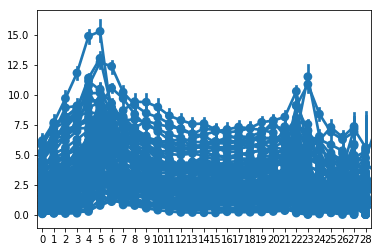

In [2]:
os.getcwd()
#path='C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\Mojo'

for monkey_directory in ['Speriatus', 'Mojo']:
    path = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\' +monkey_directory
    #path='C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\'+monkey_directory
    os.chdir(path)
    Monkey = path.split('\\')[-1]
    print('Number of neurons = ' + str(len(os.listdir())))

    for file_to_use in range(0, len(os.listdir()) ):  #
        os.chdir(path)
        print(  monkey_directory + ' ' + str(file_to_use))
        file_numb=file_to_use
        file = os.listdir()[file_numb]
        print(file)
        # import file into a dictionary
        f = scipy.io.loadmat(file)
        #
        ## Get the RF features
        x_rf=f['data']['info'][0][0][0][1][0][25][0][0]
        y_rf=f['data']['info'][0][0][0][1][0][26][0][0]
        RF_angle = pos_xy_to_angle(x_rf, y_rf)
        RF_loc = RFangle_2_octaves(RF_angle)

        np.shape(f['data']['spikes'][0][0][0])

        #Continue if data

        if np.shape(f['data']['spikes'][0][0][0]) ==(0,):
            print('No data')
            #break()

        else:        
            #Spikes times
            df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
            np.shape(df_spike_time)
            df_spike_time.iloc[:, 0]
            df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]


            ### Events
            Dict_events={}

            for i in range(0, len(f['data']['events'][0][0][0])     ):
                events = pd.DataFrame( f['data']['events'][0][0][0][i])
                events.columns=['time', 'code']
                Dict_events[str(i)]= events


            ### Descriptors & Bad trials
            ## Use the Descriptors to take the booleans to use
            lists=[]
            for T in range(0, len(f['data']['descriptors'][0][0][0])):
                lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )



            #
            Descriptors = pd.DataFrame(lists)
            Descriptors=Descriptors.transpose()
            Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]

            ## 26 descriptot for each trial
            # 6 = 1 for success, 14== antisacade, 15==othersacade
            boolean_success_trials = Descriptors.iloc[6].isin([1, 14, 15]) #Descriptors.iloc[6,:]==1

            # 24  0, 1, 2 for target in RF 
            #boolean_TinRF_trials = Descriptors.iloc[24].isin([0,1,2])

            ##Use the bad to take the booleans of bad trials
            #Bad trials
            bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
            bad = bad.transpose()
            bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]

            #print(shape(bad))
            #each column in a trial; if 1, discard it
            boolean_correct_trials = bad.iloc[0,:]!=1



            #Boolean combinging success trials and correct
            boolean_keep = boolean_success_trials & boolean_correct_trials 
            print('Trials keep = ' +str(sum(boolean_keep)))
            print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))

            #df_spikes_correct
            indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
            df_spikes = df_spike_time[list(indexes_trials_keep)]
            df_spikes = df_spikes.iloc[4:, :]
            #take off columns full of nans (after the first 4, the rest was nan)
            df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() 



            #
            ### Convert the df_spikes to count_spikes
            def count_spikes(data, start=0, wind=100):
                max_value = int(data[data<9999].max())
                windows = np.arange(start, max_value, wind)

                counts=[]

                for idx, w in enumerate(list(windows)[:-1]):
                    counts.append(sum((data>w) & (data<windows[idx+1])))

                return counts


            ## Not all the trials are equally long. Windows starting at the target onset
            number_count=[]
            for TRIAL in list(df_spikes.columns):
                try:
                    target_onset = Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==6, 'time'].values[0]
                except IndexError:
                    try:
                        target_onset = Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==7, 'time'].values[0] -100
                    except IndexError:
                        pass

                ####
                spike_count_column = count_spikes(df_spikes[TRIAL],start=target_onset-400, wind=100)
                #### you need to have the max len for the next matrix
                number_count.append(len(spike_count_column))



            ### Dataframe with the spike count in the windows 
            df_count = pd.DataFrame(np.nan, index=list(range(0, max(number_count))) , columns=list(df_spikes.columns))

            for TRIAL in list(df_spikes.columns):    
                try:
                    target_onset = Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==6, 'time'].values[0]
                    spike_count_column = count_spikes(df_spikes[TRIAL], start=target_onset -400, wind=100)
                    df_count[TRIAL].iloc[0:len(spike_count_column)] = spike_count_column
                except IndexError:
                    try:
                        target_onset = Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==7, 'time'].values[0] -100
                        spike_count_column = count_spikes(df_spikes[TRIAL], start=target_onset-400, wind=100)
                        df_count[TRIAL].iloc[0:len(spike_count_column)] = spike_count_column
                    except IndexError:
                        pass


                ####
                #spike_count_column = count_spikes(df_spikes[TRIAL], start=target_onset, wind=100)
                #df_count[TRIAL].iloc[0:len(spike_count_column)] = spike_count_column


            #df_count


            #Profile of a neuron rate (mean for window)
            Matrix =df_count.transpose()
            #Matrix
            sns.pointplot(data=Matrix)


            #(trials, times)
            #np.shape(Matrix)
            #os.chdir('C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\David fixation')
            os.chdir('C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\firing_rates')

            #Dictionary to save
            Matrix_events={}
            name_dict = file.split('.')[0]

            TRIALS = {}
            for i in list(Matrix.index):
                TRIALS[i] = Dict_events[i]

            Matrix_events['data'] = Matrix
            Matrix_events['monkey'] = Monkey
            Matrix_events['trials'] =TRIALS
            #### Descriptors
            Descriptors_use = Descriptors[list(Matrix_events['trials'].keys())]
            Targets_locations = Descriptors_use.loc[1].values
            Targets_loc = [angle_from_RF(t, RF_loc) for t in Targets_locations]
            Descriptors_use.loc[26]=RF_angle #### the specific RF angle (0, 360 of the target)
            Descriptors_use.loc[27]=RF_loc  ##### the RF loc of the target (0, 45, 90, 135...)
            Descriptors_use.loc[28]=Targets_loc  ### the real angle of the target (0,45,90.....)

            Distractors_locations = Descriptors_use.loc[19].values
            Distractors_loc = [angle_from_RF(d, RF_loc) for d in Distractors_locations]
            Descriptors_use.loc[29]=Distractors_loc #### the real angle of the distractor (0, 45, 90...)


            Centered_target = [circdist(Descriptors_use.loc[27][i], Descriptors_use.loc[28][i]) for i in range(0, len(Descriptors_use.loc[28]))]
            Descriptors_use.loc[30]=Centered_target

            target_180_180 = Descriptors_use.loc[28] - Descriptors_use.loc[27]
            for n in range(0, len(target_180_180)):
                if target_180_180[n] >180:
                    target_180_180[n]= target_180_180[n]-360


            Descriptors_use.loc[31]=target_180_180

            real_target_loc = Descriptors_use.loc[27] + Descriptors_use.loc[31]

            ##### real_target_loc
            for i in range(0, len(real_target_loc)):
                if real_target_loc[i]<0:
                    real_target_loc[i] = 360 + real_target_loc[i]


            Descriptors_use.loc[32] = real_target_loc
            ###
            Matrix_events['Descriptor'] =Descriptors_use
            
            ####
            #### Normalized firing rate
            #Trials_norm_FR = Matrix_events['Descriptor'].columns[(Matrix_events['Descriptor'].loc[20]==0) & (Matrix_events['Descriptor'].loc[24]==0)] ## distractors of 0ms
            Trials_norm_FR = Matrix_events['Descriptor'].columns[Matrix_events['Descriptor'].loc[19]==99] ##the no distractors
            FR_cont = Matrix_events['data'].loc[Trials_norm_FR]
            #max_fr = FR_cont.max().max()
            max_fr = FR_cont.mean().max()
            Matrix_events['data_norm'] = Matrix_events['data']/max_fr

            ### Save
            np.save( name_dict + '.npy', Matrix_events) 







In [ ]:
file='1364705.mat'

In [54]:
file='1369901.mat'

In [55]:
f = scipy.io.loadmat(file)

In [56]:
np.shape(f['data']['spikes'][0][0][0]) ==(0,)

False

In [57]:
df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]

,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
4,6.979167,42.020833,58.875000,18.104167,267.458333,4.791667,424.541667,347.333333,10.020833,305.666667,...,15.854167,6.000000,107.125000,115.666667,71.041667,25.145833,53.062500,22.937500,67.208333,47.833333
5,28.770833,51.770833,186.937500,390.187500,299.083333,127.833333,461.604167,380.500000,297.520833,503.875000,...,35.958333,7.145833,157.229167,123.895833,83.791667,103.750000,72.145833,38.812500,166.437500,104.645833
6,56.979167,394.666667,196.333333,441.145833,381.583333,129.395833,504.125000,386.541667,395.687500,511.375000,...,93.958333,22.020833,209.541667,168.520833,93.270833,146.541667,126.312500,45.520833,547.083333,130.416667
7,58.270833,419.312500,256.687500,443.458333,438.916667,175.541667,511.125000,387.458333,417.062500,590.083333,...,100.729167,76.000000,247.041667,200.437500,94.958333,196.937500,221.437500,52.166667,620.437500,134.291667
8,62.541667,456.583333,391.416667,465.708333,451.937500,204.062500,511.770833,423.895833,441.437500,591.250000,...,113.250000,107.416667,286.187500,221.104167,123.270833,200.604167,291.312500,71.854167,631.125000,142.854167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
### Events
Dict_events={}

for i in range(0, len(f['data']['events'][0][0][0])     ):
    events = pd.DataFrame( f['data']['events'][0][0][0][i])
    events.columns=['time', 'code']
    Dict_events[str(i)]= events


### Descriptors & Bad trials
## Use the Descriptors to take the booleans to use
lists=[]
for T in range(0, len(f['data']['descriptors'][0][0][0])):
    lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )



#
Descriptors = pd.DataFrame(lists)
Descriptors=Descriptors.transpose()
Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]

## 26 descriptot for each trial
# 6 = 1 for success, 14== antisacade, 15==othersacade
boolean_success_trials = Descriptors.iloc[6].isin([1]) #Descriptors.iloc[6,:]==1

# 24  0, 1, 2 for target in RF 
#boolean_TinRF_trials = Descriptors.iloc[24].isin([0,1,2])

##Use the bad to take the booleans of bad trials
#Bad trials
bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
bad = bad.transpose()
bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]

#print(shape(bad))
#each column is a trial; if 1, discard it
boolean_correct_trials = bad.iloc[0,:]!=1



#Boolean combinging success trials and correct
boolean_keep = boolean_success_trials & boolean_correct_trials 
print('Trials keep = ' +str(sum(boolean_keep)))
print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))

Trials keep = 303
Trials excluded = 115


In [60]:
boolean_keep

0       True
1       True
2       True
3       True
4       True
       ...  
413    False
414    False
415    False
416    False
417    False
Length: 418, dtype: bool

In [61]:
indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
df_spikes = df_spike_time[list(indexes_trials_keep)]
df_spikes = df_spikes.iloc[4:, :]
df_spikes

,0,1,2,3,4,5,6,8,9,11,...,388,390,391,392,395,396,397,398,406,407
4,6.979167,42.020833,58.875000,18.104167,267.458333,4.791667,424.541667,10.020833,305.666667,104.562500,...,34.000000,12.791667,165.333333,171.208333,33.791667,179.791667,32.812500,5.708333,28.104167,31.000000
5,28.770833,51.770833,186.937500,390.187500,299.083333,127.833333,461.604167,297.520833,503.875000,550.604167,...,175.791667,25.916667,437.895833,180.604167,42.687500,227.583333,60.354167,17.500000,129.500000,59.916667
6,56.979167,394.666667,196.333333,441.145833,381.583333,129.395833,504.125000,395.687500,511.375000,552.750000,...,386.895833,37.104167,483.208333,216.562500,89.354167,595.354167,329.708333,63.375000,147.541667,125.208333
7,58.270833,419.312500,256.687500,443.458333,438.916667,175.541667,511.125000,417.062500,590.083333,571.458333,...,401.875000,56.625000,548.541667,333.958333,139.687500,716.312500,352.437500,175.291667,256.583333,162.104167
8,62.541667,456.583333,391.416667,465.708333,451.937500,204.062500,511.770833,441.437500,591.250000,582.604167,...,414.333333,393.250000,598.395833,377.520833,205.770833,754.458333,395.708333,209.333333,316.729167,366.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() 
df_spikes

,0,1,2,3,4,5,6,8,9,11,...,388,390,391,392,395,396,397,398,406,407
4,6.979167,42.020833,58.875000,18.104167,267.458333,4.791667,424.541667,10.020833,305.666667,104.562500,...,34.000000,12.791667,165.333333,171.208333,33.791667,179.791667,32.812500,5.708333,28.104167,31.000000
5,28.770833,51.770833,186.937500,390.187500,299.083333,127.833333,461.604167,297.520833,503.875000,550.604167,...,175.791667,25.916667,437.895833,180.604167,42.687500,227.583333,60.354167,17.500000,129.500000,59.916667
6,56.979167,394.666667,196.333333,441.145833,381.583333,129.395833,504.125000,395.687500,511.375000,552.750000,...,386.895833,37.104167,483.208333,216.562500,89.354167,595.354167,329.708333,63.375000,147.541667,125.208333
7,58.270833,419.312500,256.687500,443.458333,438.916667,175.541667,511.125000,417.062500,590.083333,571.458333,...,401.875000,56.625000,548.541667,333.958333,139.687500,716.312500,352.437500,175.291667,256.583333,162.104167
8,62.541667,456.583333,391.416667,465.708333,451.937500,204.062500,511.770833,441.437500,591.250000,582.604167,...,414.333333,393.250000,598.395833,377.520833,205.770833,754.458333,395.708333,209.333333,316.729167,366.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
def count_spikes(data, start=0, wind=100):
    max_value = int(data[data<9999].max())
    windows = np.arange(start, max_value, wind)

    counts=[]

    for idx, w in enumerate(list(windows)[:-1]):
        counts.append(sum((data>w) & (data<windows[idx+1])))

    return counts

In [78]:
TRIAL='3'

In [79]:
df_spikes
#### cada columna es un trial!

,0,1,2,3,4,5,6,8,9,11,...,388,390,391,392,395,396,397,398,406,407
4,6.979167,42.020833,58.875000,18.104167,267.458333,4.791667,424.541667,10.020833,305.666667,104.562500,...,34.000000,12.791667,165.333333,171.208333,33.791667,179.791667,32.812500,5.708333,28.104167,31.000000
5,28.770833,51.770833,186.937500,390.187500,299.083333,127.833333,461.604167,297.520833,503.875000,550.604167,...,175.791667,25.916667,437.895833,180.604167,42.687500,227.583333,60.354167,17.500000,129.500000,59.916667
6,56.979167,394.666667,196.333333,441.145833,381.583333,129.395833,504.125000,395.687500,511.375000,552.750000,...,386.895833,37.104167,483.208333,216.562500,89.354167,595.354167,329.708333,63.375000,147.541667,125.208333
7,58.270833,419.312500,256.687500,443.458333,438.916667,175.541667,511.125000,417.062500,590.083333,571.458333,...,401.875000,56.625000,548.541667,333.958333,139.687500,716.312500,352.437500,175.291667,256.583333,162.104167
8,62.541667,456.583333,391.416667,465.708333,451.937500,204.062500,511.770833,441.437500,591.250000,582.604167,...,414.333333,393.250000,598.395833,377.520833,205.770833,754.458333,395.708333,209.333333,316.729167,366.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==6, 'time'].values[0]

304

In [81]:
trial_start = Dict_events[TRIAL].loc[Dict_events[TRIAL]['code']==1, 'time'].values[0]
trial_start

1

In [82]:
spike_count_column = count_spikes(df_spikes[TRIAL],start=trial_start, wind=100)

In [84]:
data = df_spikes[TRIAL]
###times in ms of the time an spike happened

def count_spikes(data, start=0, wind=100):
    max_value = int(data[data<9999].max())
    windows = np.arange(start, max_value, wind)

    counts=[]

    for idx, w in enumerate(list(windows)[:-1]):
        counts.append(sum((data>w) & (data<windows[idx+1])))

    return counts

4       18.104167
5      390.187500
6      441.145833
7      443.458333
8      465.708333
          ...    
312           NaN
313           NaN
314           NaN
315           NaN
316           NaN
Name: 3, Length: 313, dtype: float64

In [229]:
from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import mean_firing_rate
from elephant.statistics import time_histogram, instantaneous_rate
from elephant.kernels import GaussianKernel


In [230]:
times_spikes_all = df_spikes[TRIAL].values # get trial spike times
times_spikes = times_spikes_all[times_spikes_all<9999] ##remove nans
stop_time =  times_spikes.max()
spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time)


inst_rate = instantaneous_rate(spiketrain1, sampling_period=100*ms)
gaus_rate = instantaneous_rate(spiketrain1, sampling_period=100*ms, kernel=GaussianKernel(15*ms))


times_ = gaus_rate.times.rescale(ms)
firing_auto = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


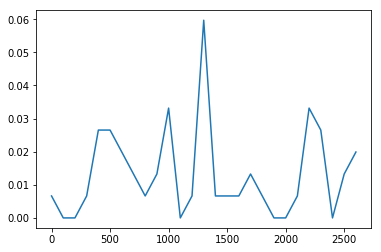

In [231]:
plt.plot(times_, firing_gauss)

In [137]:
mean_firing_rate(spiketrain1)

array(0.02031254) * 1/ms

In [251]:


histogram_count = time_histogram([spiketrain1], 10*ms)
histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate')

inst_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms)

C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


In [252]:


gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms))


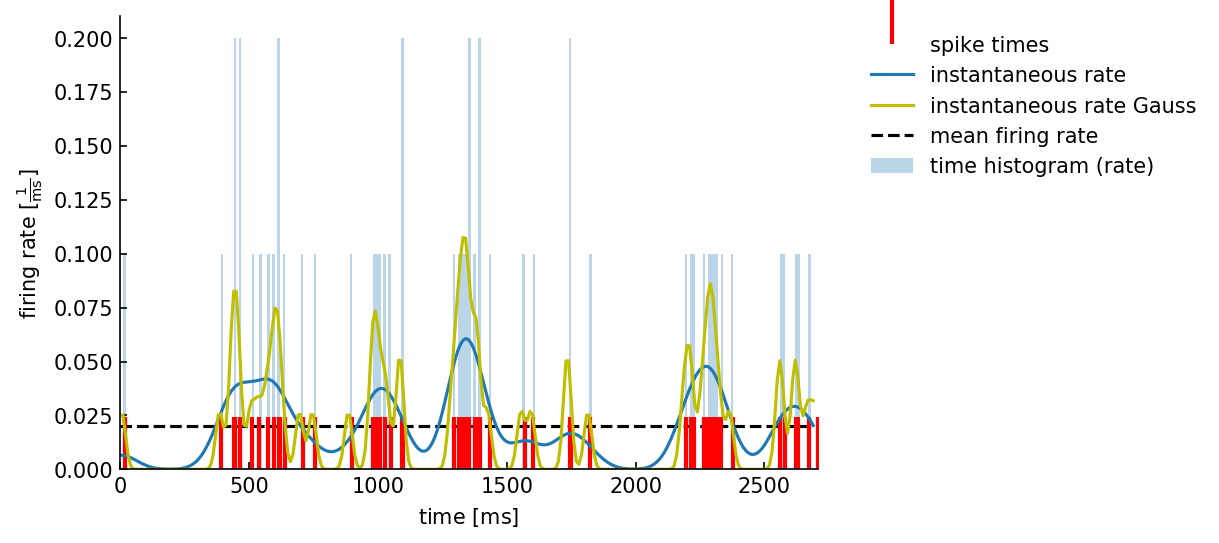

In [253]:
plt.figure(dpi=150)

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# time histogram
plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')

# instantaneous rate
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')

# instantaneous rate gausss
plt.plot(gaus_rate.times.rescale(ms), gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='y', label='instantaneous rate Gauss')


# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend( frameon=False, bbox_to_anchor=(1.05, 1))
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()

TypeError: 'memoryview' object is not callable

In [226]:
inst_rate.times.rescale(ms)

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.]) * ms

In [225]:
x = gaus_rate.times.rescale(ms)
y = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
A = pd.DataFrame({'times':x, 'firing':y})
A

,firing,times
0,6.631809e-03,0.0
1,1.939747e-17,100.0
2,9.911463e-08,200.0
3,6.632206e-03,300.0
4,2.652763e-02,400.0
5,2.652753e-02,500.0
6,1.989563e-02,600.0
7,1.326372e-02,700.0
8,6.632007e-03,800.0
9,1.326411e-02,900.0


In [201]:
1352*2

2704

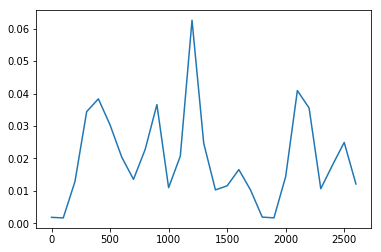

In [164]:
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten())

In [165]:
inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()

array([0.00185733, 0.00167995, 0.01286943, 0.03439727, 0.03835633,
       0.03031026, 0.02037834, 0.01356066, 0.02279671, 0.03658894,
       0.01099969, 0.02071571, 0.06256379, 0.02467938, 0.01030696,
       0.01156425, 0.01656275, 0.01027299, 0.00192465, 0.00170407,
       0.01441941, 0.04089806, 0.0355394 , 0.01067319, 0.01795476,
       0.02493535, 0.01213974])

In [166]:
inst_rate.times.rescale(ms)

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
       1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.]) * ms

In [160]:
inst_rate.times

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.350e+03, 1.351e+03,
       1.352e+03]) * (0.002*s)

In [87]:
spike_count_column

windows = np.arange(trial_start, max_value, 100)
windows

array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101,
       2201, 2301, 2401, 2501, 2601, 2701])

In [105]:
from elephant.statistics import mean_firing_rate
from elephant.statistics import time_histogram, instantaneous_rate
from quantities import ms, s, Hz

In [91]:
mean_firing_rate(data[data<9999].values)

0.02031253606629273

In [92]:
len(data[data<9999].values) / (max_value - trial_start)  ##number of spikes / time

0.02032520325203252

In [131]:
from neo.core import SpikeTrain
spiketrain11 = SpikeTrain(spiketrain1*ms, t_stop=max_value)

In [124]:
spiketrain1

array([  18.10416667,  390.1875    ,  441.14583333,  443.45833333,
        465.70833333,  466.16666667,  510.3125    ,  540.125     ,
        573.9375    ,  597.79166667,  616.64583333,  619.70833333,
        638.375     ,  707.60416667,  753.75      ,  897.5625    ,
        980.52083333,  997.4375    , 1006.79166667, 1028.83333333,
       1049.3125    , 1093.91666667, 1095.45833333, 1297.0625    ,
       1316.20833333, 1329.52083333, 1331.375     , 1342.33333333,
       1351.02083333, 1353.6875    , 1376.02083333, 1391.0625    ,
       1397.95833333, 1435.6875    , 1569.8125    , 1600.72916667,
       1743.75      , 1748.125     , 1823.6875    , 2196.6875    ,
       2213.4375    , 2228.54166667, 2263.97916667, 2280.58333333,
       2297.95833333, 2307.3125    , 2318.27083333, 2331.20833333,
       2379.1875    , 2560.25      , 2579.27083333, 2624.27083333,
       2630.58333333, 2671.47916667, 2707.6875    ])

In [129]:
max_value = spiketrain1.max()
max_value

2707.6875

In [106]:
spiketrain1 = data[data<9999].values
t_start=trial_start
t_stop=max_value

In [107]:
inst_rate = instantaneous_rate(spiketrain1, sampling_period=2*ms)

TypeError: 'spiketrain' must be an instance of neo.SpikeTrain. 
Found: '<class 'numpy.ndarray'>'

In [113]:
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process

spiketrain2 = homogeneous_gamma_process(a=3, b=10*Hz, t_start=0.*ms, t_stop=10000.*ms)
spiketrain2

SpikeTrain

In [118]:
from elephant.spike_train_generation import spike_extraction

In [123]:
spike_extraction(signal=spiketrain1)

AttributeError: 'numpy.ndarray' object has no attribute 'times'

In [108]:
spiketrain1

array([  18.10416667,  390.1875    ,  441.14583333,  443.45833333,
        465.70833333,  466.16666667,  510.3125    ,  540.125     ,
        573.9375    ,  597.79166667,  616.64583333,  619.70833333,
        638.375     ,  707.60416667,  753.75      ,  897.5625    ,
        980.52083333,  997.4375    , 1006.79166667, 1028.83333333,
       1049.3125    , 1093.91666667, 1095.45833333, 1297.0625    ,
       1316.20833333, 1329.52083333, 1331.375     , 1342.33333333,
       1351.02083333, 1353.6875    , 1376.02083333, 1391.0625    ,
       1397.95833333, 1435.6875    , 1569.8125    , 1600.72916667,
       1743.75      , 1748.125     , 1823.6875    , 2196.6875    ,
       2213.4375    , 2228.54166667, 2263.97916667, 2280.58333333,
       2297.95833333, 2307.3125    , 2318.27083333, 2331.20833333,
       2379.1875    , 2560.25      , 2579.27083333, 2624.27083333,
       2630.58333333, 2671.47916667, 2707.6875    ])

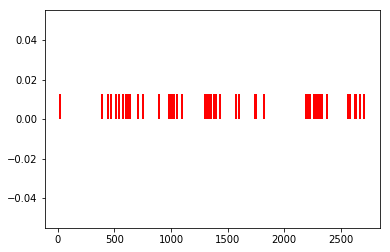

In [110]:
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='poisson spike times')

In [111]:
spiketrain1
histogram_count = time_histogram([spiketrain1], 100*ms)

AttributeError: (AttributeError("'numpy.ndarray' object has no attribute 't_start'",), 'Please provide t_start or t_stop')

NameError: name 'histogram_rate' is not defined

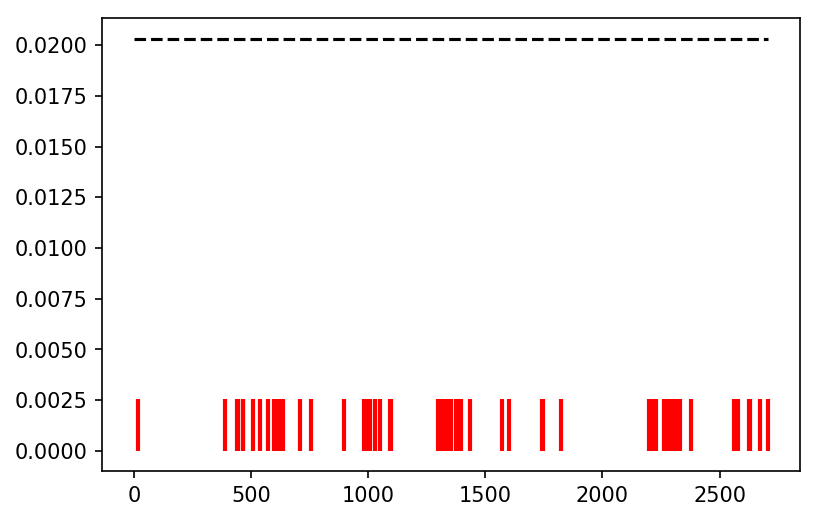

In [101]:
plt.figure(dpi=150)

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='poisson spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=t_start, xmax=t_stop, linestyle='--', label='mean firing rate')

# time histogram
plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')

# instantaneous rate
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')

# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend()
plt.show()

In [68]:
Dict_events[TRIAL]

,time,code
0,1,1
1,2,4
2,3,5
3,304,26
4,304,6
5,404,27
6,404,7
7,1204,31
8,1204,30
9,1304,32


In [236]:
df_spikes.columns

Index(['0', '1', '2', '3', '4', '5', '6', '8', '9', '11',
       ...
       '388', '390', '391', '392', '395', '396', '397', '398', '406', '407'],
      dtype='object', length=303)

In [240]:
Descriptors_use = Descriptors[list(df_spikes.columns)]
Descriptors_use[TRIAL]

0      99
1       1
2     115
3       8
4      75
5      90
6       1
7     100
8     400
9     300
10    100
11     75
12    150
13      1
14      1
15      1
16    101
17    350
18      1
19      0
20    800
21    100
22    700
23      1
24      3
25     99
Name: 3, dtype: int64

In [242]:
Descriptors_use[TRIAL].iloc[24]

3

In [257]:
path_save = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\firing_rates'
path_save_neuron = os.path.join(path_save, neuron+'.xlsx')

In [258]:
path_save_neuron

'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\firing_rates\\1376101.xlsx'

In [ ]:

for monkey_directory in ['Speriatus', 'Mojo']:
    path = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\' +monkey_directory
    path = 'C:\\Users\\David\\Desktop\\fast_process_gottlieb\\' +monkey_directory
    Monkey = path.split('\\')[-1]
    for file_to_use in os.listdir(path):  #
        neuron = file_to_use.split('.')[0]
        print(Monkey, neuron)
        #########
        ### Open file
        f = scipy.io.loadmat(os.path.join(path, file_to_use))
        ########
        ### Check if there is spiking data inside
        if np.shape(f['data']['spikes'][0][0][0]) ==(0,): 
            print('No data')
            
        else:
            ########
            ### Spikes 
            df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
            df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            ########
            ### Events
            Dict_events={}
            for i in range(0, len(f['data']['events'][0][0][0])     ):
                events = pd.DataFrame( f['data']['events'][0][0][0][i])
                events.columns=['time', 'code']
                Dict_events[str(i)]= events
            #
            ########
            ### Descriptors & Bad trials
            ## Use the Descriptors to make the booleans to select the HIT trials
            lists=[]
            for T in range(0, len(f['data']['descriptors'][0][0][0])):
                lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )
            #
            Descriptors = pd.DataFrame(lists)
            Descriptors=Descriptors.transpose()
            Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]
            # 6 "failed" // performance code, as defined below 
            boolean_hit_trials = Descriptors.iloc[6].isin([1]) #Descriptors.iloc[6,:]==1
            ########
            ### Bad trials
            ## take off the bad trials
            bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
            bad = bad.transpose()
            bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            #each column in a trial; if 1, discard it
            boolean_bad_trials = bad.iloc[0,:]!=1
            ########
            ########
            ### Boolean combinging success trials and correct
            boolean_keep = boolean_hit_trials & boolean_bad_trials 
            print('Trials keep = ' +str(sum(boolean_keep)))
            print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))
            ########
            ### df_spikes_correct
            indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
            df_spikes = df_spike_time[list(indexes_trials_keep)]
            df_spikes = df_spikes.iloc[4:, :] #remove the first 4 rows, no spikes
            df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() #remove columns full of nans
            ########
            ########
            ########
            ### Get the firing rate of each trial (Gaussian fit and auto)
            ### turorial https://elephant.readthedocs.io/en/latest/tutorials/statistics.html
            trials_=[]            
            Descriptors_use = Descriptors[list(df_spikes.columns)]           
            for TRIAL in list(df_spikes.columns):
                ###### firing rates
                times_spikes_all = df_spikes[TRIAL].values # get trial spike times
                times_spikes = times_spikes_all[times_spikes_all<9999] ##remove nans in the trial (at the end)
                times_spikes = times_spikes[times_spikes>0] #no negative timings for spikes
                stop_time =  times_spikes.max()
                spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time) #spiketrain
                histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate') #sampling rate of 10 Suzuki & Gottlieb, increase for less temporal resolution. 
                #inst_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms) 
                gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 
                times_ = gaus_rate.times.rescale(ms)
                #firing_auto = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
                firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
                df_trial = pd.DataFrame({'times':times_, 'firing_gauss':firing_gauss}) #, 'firing_auto': firing_auto})
                                
                ####### descriptive data
                df_trial['trial']=TRIAL 
                df_trial['TDOA'] = Descriptors_use[TRIAL].iloc[20]
                df_trial['TDconf'] = Descriptors_use[TRIAL].iloc[24]
                df_trial['targetloc'] = Descriptors_use[TRIAL].iloc[1]
                df_trial['distLoc'] = Descriptors_use[TRIAL].iloc[19]
                df_trial['fixationtime'] = Descriptors_use[TRIAL].iloc[9]
                df_trial['failed'] = Descriptors_use[TRIAL].iloc[6]
                df_trial['saccadeChoice'] = Descriptors_use[TRIAL].iloc[18]
                df_trial['cueDuration'] = Descriptors_use[TRIAL].iloc[10]
                df_trial['distDur'] = Descriptors_use[TRIAL].iloc[21]
                df_trial['monkey'] = Monkey
                df_trial['neuron'] = neuron           
                trials_.append(df_trial)
            #
            df_neuron=pd.concat(trials_)
            ########
            ########
            ### Normalization
            # Get the mean of each time in the control condition (T in RF no dist), then get the max of this means
            max_fr_gauss_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_gauss', 'times']].groupby('times').describe()['firing_gauss']['mean'].max()
            #max_fr_auto_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_auto', 'times']].groupby('times').describe()['firing_auto']['mean'].max()
            df_neuron['norm_firing_gauss'] = df_neuron['firing_gauss']/max_fr_gauss_normalize
            #df_neuron['norm_firing_auto'] = df_neuron['firing_auto']/max_fr_auto_normalize
            ########
            ########
            ######## Save the dataframe as an excel with the name of the neuron
            path_save = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\firing_rates'
            path_save_neuron = os.path.join(path_save, neuron+'.xlsx')
            df_neuron.to_excel(path_save_neuron)




Speriatus 1891407
Trials keep = 368
Trials excluded = 190


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 4 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 3 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Speriatus 1891421
Trials keep = 438
Trials excluded = 96


C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 7 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


In [262]:
times_spikes

array([ 599.85416667, 1695.58333333])

In [264]:
histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate')

C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


In [266]:
gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 


In [ ]:
try:
    ax.set_ylim([y.min()-0.05, y.max()+0.05])
except ValueError:  #raised if `y` is empty.
    pass

In [9]:
max_fr = FR_cont.mean().max()

In [11]:
Matrix_events['data_norm'] = Matrix_events['data']/max_fr

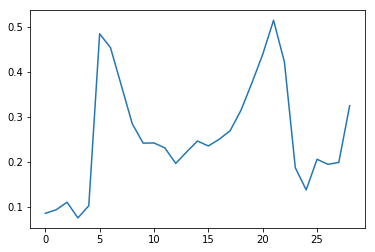

In [15]:
import matplotlib.pyplot as plt
plt.plot(Matrix_events['data_norm'].mean() )

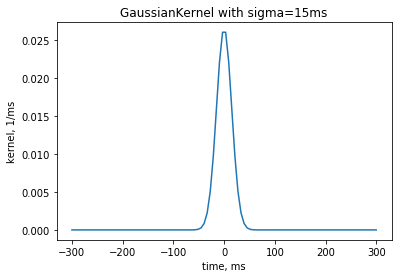

In [26]:
from elephant import kernels
import quantities as pq
import numpy as np
import matplotlib.pyplot as plt

time_array = np.linspace(-300, 300, num=100) * pq.ms
kernel = kernels.GaussianKernel(sigma=15*pq.ms)
kernel_time = kernel(time_array)
plt.plot(time_array, kernel_time)
plt.title("GaussianKernel with sigma=15ms")
plt.xlabel("time, ms")
plt.ylabel("kernel, 1/ms")
plt.show()

In [19]:
kernels.GaussianKernel(sigma=15*pq.ms)

GaussianKernel(sigma=15.0 ms, invert=False)

In [18]:
np.linspace(-3, 3, num=100) 

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18

In [27]:
df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [28]:
f['data']['spikes'][0][0][0][0][:, :]

IndexError: index 0 is out of bounds for axis 0 with size 0